## 데이터 준비

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california = fetch_california_housing()

df = pd.DataFrame(california.data, columns=california.feature_names)
df['Target'] = california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


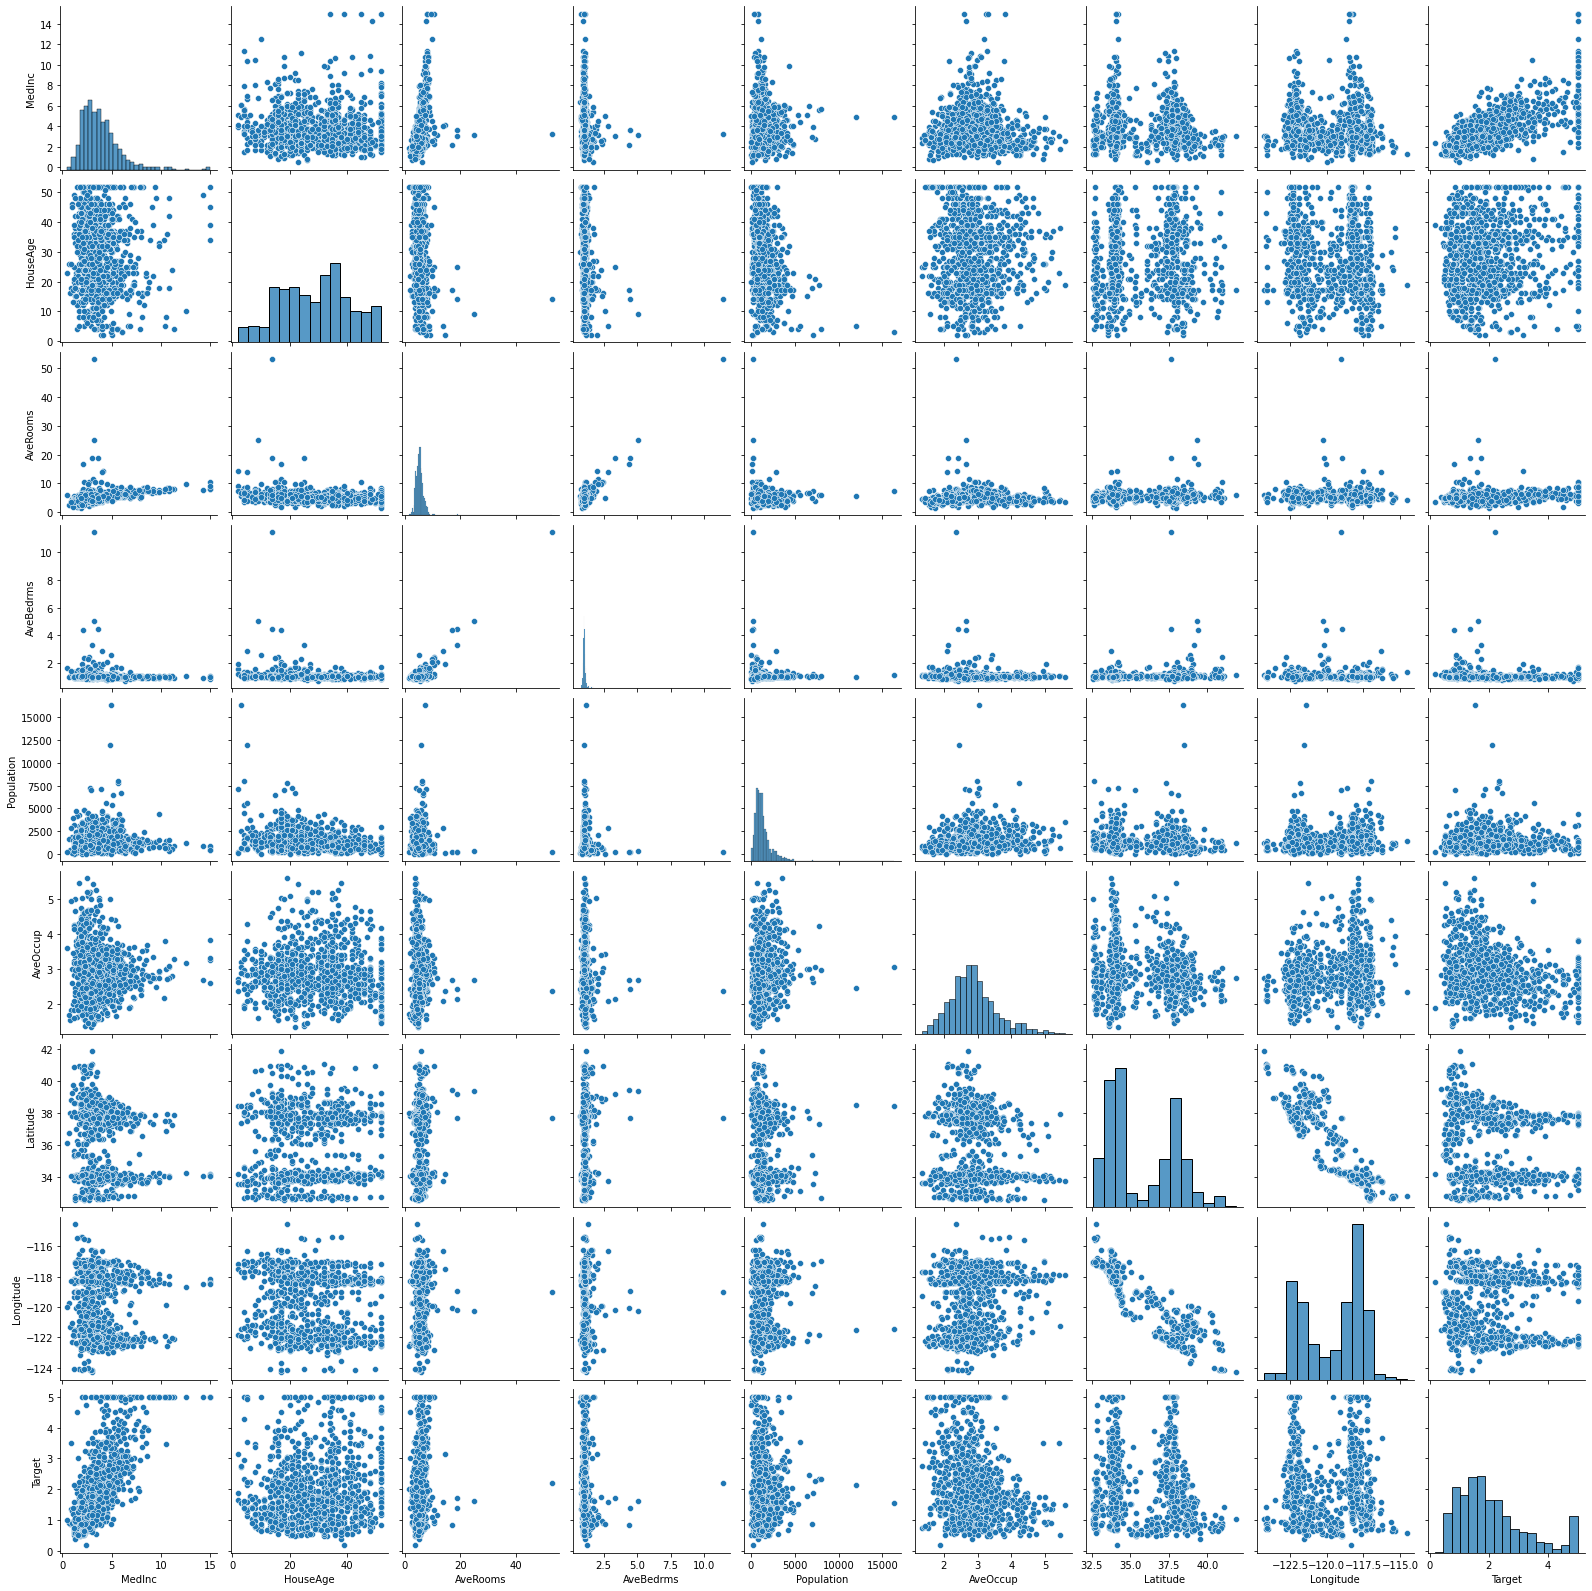

In [3]:
sns.pairplot(df.sample(1000))
plt.show()

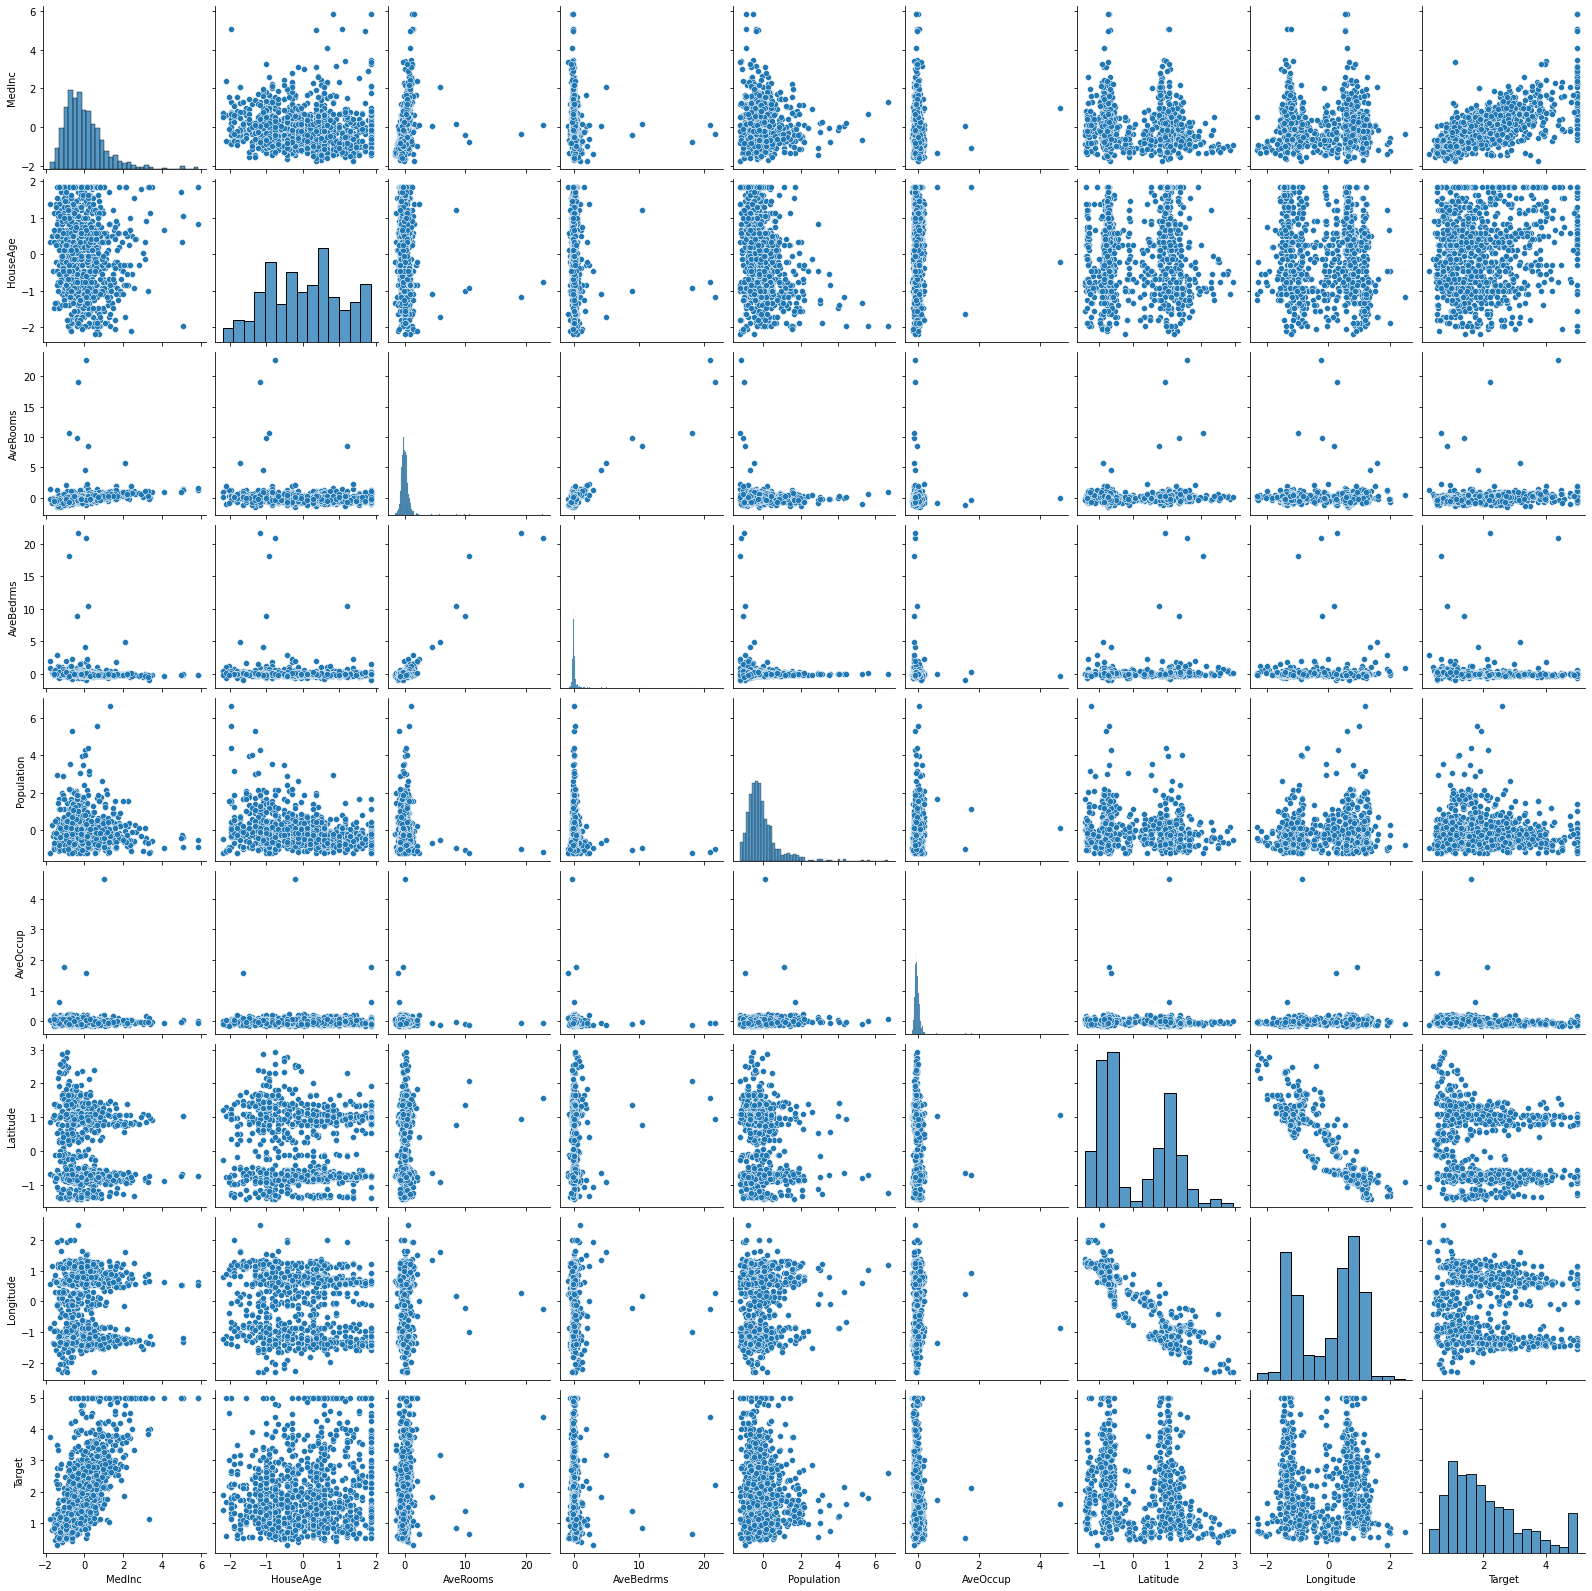

In [4]:
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.values[:,:-1] = scaler.transform(df.values[:,:-1])
sns.pairplot(df.sample(1000))
plt.show()

## 학습 코드 구현

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
data = torch.from_numpy(df.values).float()
print(data.shape)

torch.Size([20640, 9])


In [8]:
x = data[:,:-1]
y = data[:,-1:]
print(x.shape, y.shape)

torch.Size([20640, 8]) torch.Size([20640, 1])


In [9]:
n_epochs = 4000
batch_size = 256
print_interval = 200
learning_rate = 1e-2

In [10]:
model = nn.Sequential(
    nn.Linear(x.size(-1), 6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)),
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [11]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [12]:

for i in range(n_epochs):
    # Shuffle the index to feed-forward.
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim=0, index=indices)
    y_ = torch.index_select(y, dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss)
        y_hat += [y_hat_i]

        total_loss = total_loss / len(x_)
        if (i + 1) % print_interval == 0:
            print('Epoch %d : Loss=%.4e' % (i + 1, total_loss))

y_hat = torch.cat(y_hat, dim=0)
y = torch.cat(y_, dim=0)

Epoch 200 : Loss=5.5535e-03
Epoch 200 : Loss=3.1153e-03
Epoch 200 : Loss=3.9024e-03
Epoch 200 : Loss=3.8808e-03
Epoch 200 : Loss=3.8792e-03
Epoch 200 : Loss=3.6585e-03
Epoch 200 : Loss=4.2953e-03
Epoch 200 : Loss=5.1058e-03
Epoch 200 : Loss=3.8874e-03
Epoch 200 : Loss=4.3349e-03
Epoch 200 : Loss=4.1994e-03
Epoch 200 : Loss=4.5171e-03
Epoch 200 : Loss=4.3598e-03
Epoch 200 : Loss=3.7120e-03
Epoch 200 : Loss=4.1697e-03
Epoch 200 : Loss=3.2211e-03
Epoch 200 : Loss=3.5047e-03
Epoch 200 : Loss=3.8182e-03
Epoch 200 : Loss=5.4091e-03
Epoch 200 : Loss=4.2360e-03
Epoch 200 : Loss=3.3126e-03
Epoch 200 : Loss=3.1820e-03
Epoch 200 : Loss=4.3856e-03
Epoch 200 : Loss=3.3997e-03
Epoch 200 : Loss=3.3839e-03
Epoch 200 : Loss=4.6472e-03
Epoch 200 : Loss=3.3091e-03
Epoch 200 : Loss=4.0652e-03
Epoch 200 : Loss=3.9074e-03
Epoch 200 : Loss=3.6142e-03
Epoch 200 : Loss=3.2326e-03
Epoch 200 : Loss=3.9880e-03
Epoch 200 : Loss=3.3012e-03
Epoch 200 : Loss=3.6707e-03
Epoch 200 : Loss=3.1371e-03
Epoch 200 : Loss=4.2

## 결과 확인

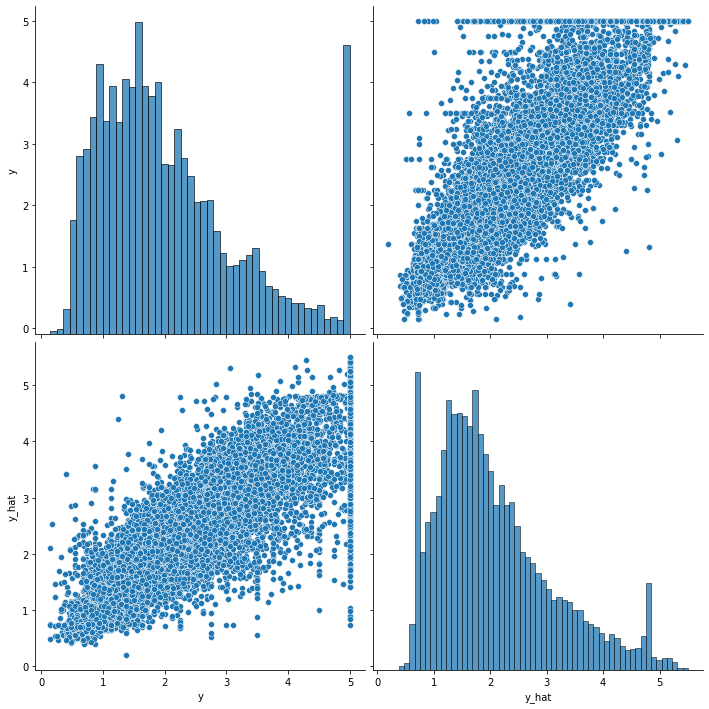

In [13]:
df = pd.DataFrame(torch.cat([y, y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])
sns.pairplot(df, height=5)
plt.show()